In [1]:
!pip install -q gitpython sentence-transformers faiss-cpu tqdm rank-bm25

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 54.7 MB/s eta 0:00:00:00:0100:01


In [2]:
# imports 

import os
import json
from pathlib import Path
import git
import faiss
import numpy as np

from tqdm import tqdm
from rank_bm25 import BM25Okapi
from sentence_transformers import SentenceTransformer, CrossEncoder

import torch


import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [3]:
# Config
GITHUB_REPO_URL = "https://github.com/viarotel-org/escrcpy"
REPO_LOCAL_PATH = Path("temp_escrcpy_repo")
REFERENCE_JSON_PATH = Path("/kaggle/input/llm-listwise-reranker-for-coderag-jetbrains/escrcpy-commits-generated.json")

VECTOR_MODEL_NAME = "microsoft/unixcoder-base"
CROSS_ENCODER_MODEL_NAME = "cross-encoder/ms-marco-MiniLM-L-12-v2"

ALLOWED_EXTENSIONS = [".js",".ts",".vue",".md",".json",".py",".yml",".yaml",".html",".css"]

BM25_K = 200
EMB_K = 200
RERANK_CANDIDATES = 400
TOP_K = 10

# Hard limit on file size in characters or lines, to skip insane files:
MAX_FILE_CHAR_LENGTH = 200_000

Summary statistics for question lengths:
count     34.000000
mean     102.676471
std       47.157197
min       23.000000
25%       75.000000
50%       88.500000
75%      105.000000
max      213.000000
Name: question_length, dtype: float64

Summary statistics for files count:
count    34.000000
mean      2.117647
std       2.142849
min       1.000000
25%       1.000000
50%       1.000000
75%       3.000000
max      10.000000
Name: files_count, dtype: float64


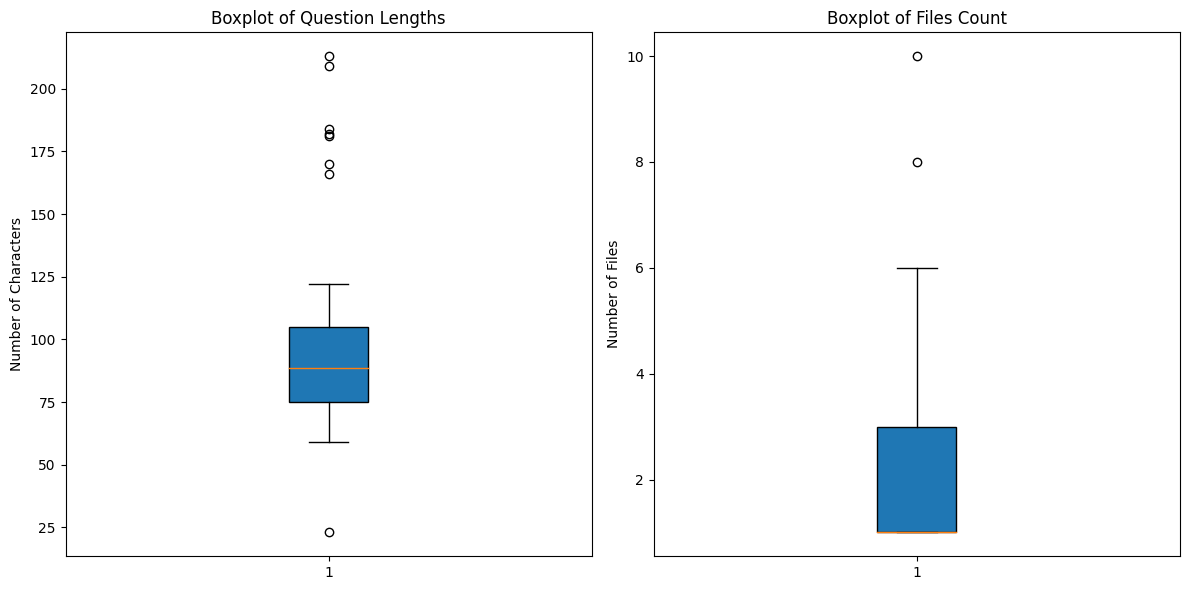

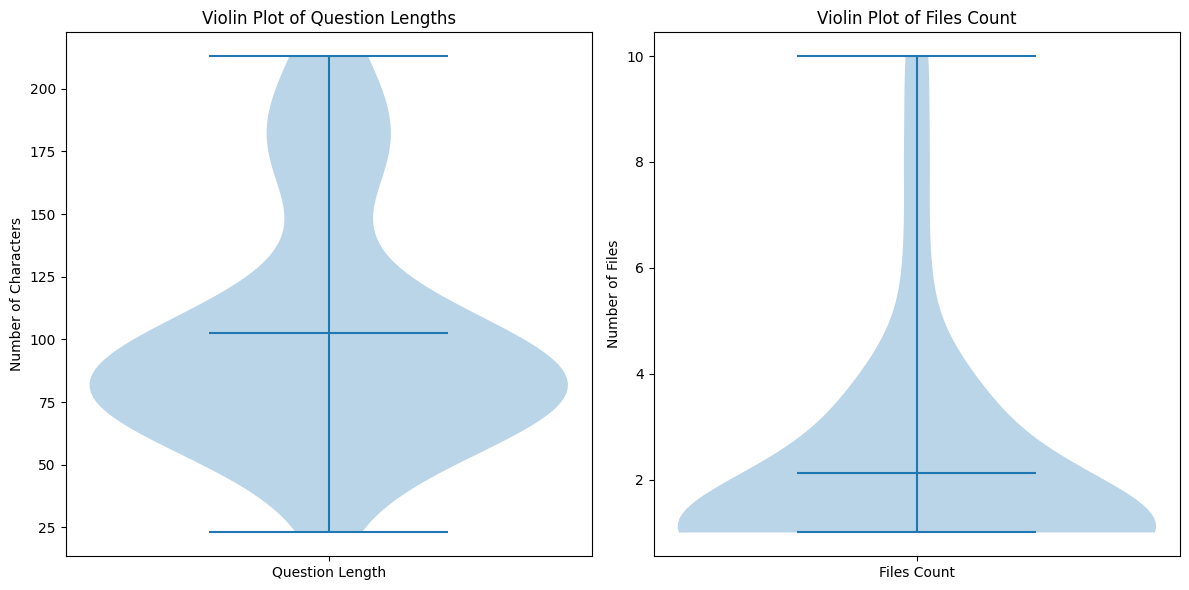

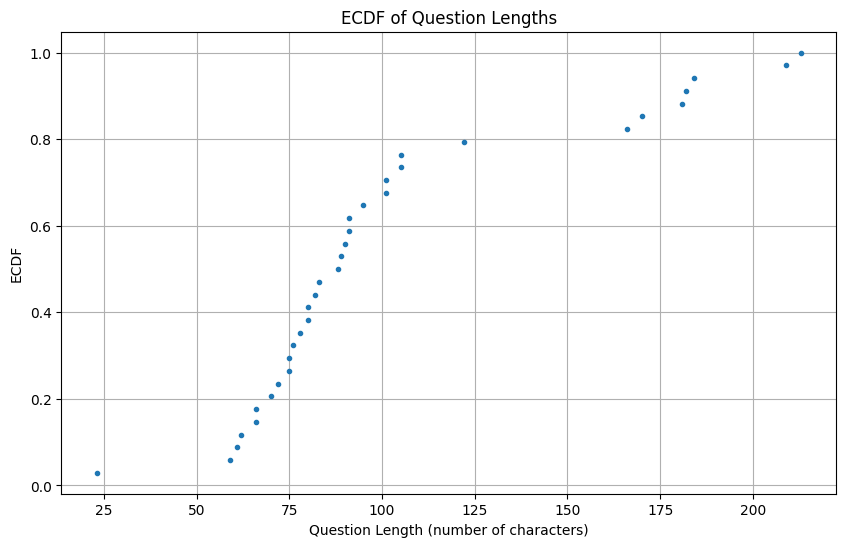

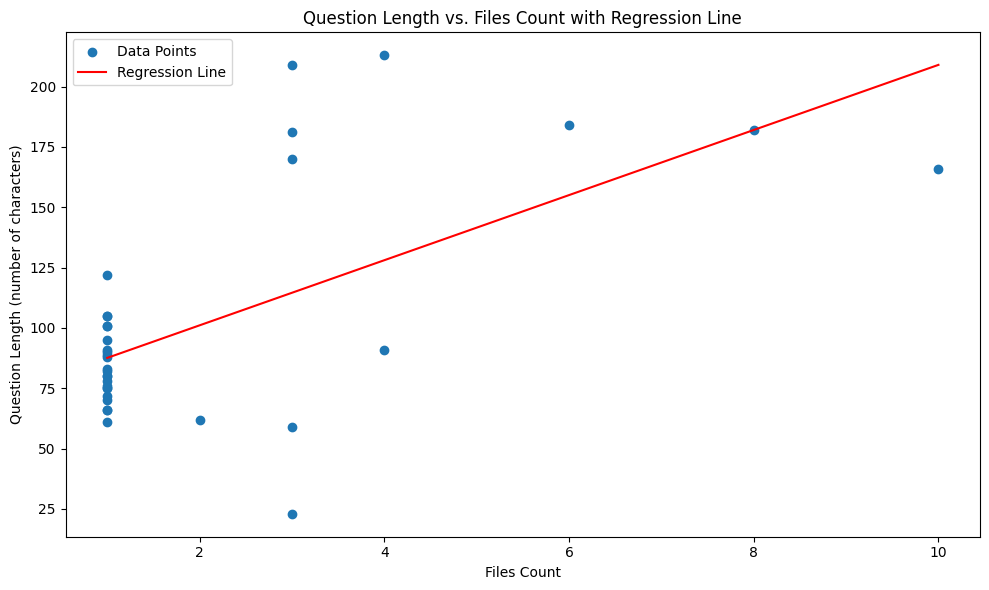

Pearson correlation coefficient: 0.6130416135016027


In [4]:
# Visualisation

with open(f'{REFERENCE_JSON_PATH}', 'r') as f:
    commits = json.load(f)

df = pd.DataFrame(commits)

# Compute a new column 'question_length' which is the number of characters in each question.
df['question_length'] = df['question'].apply(len)

# Compute a new column 'files_count' representing the number of files associated with each entry.
df['files_count'] = df['files'].apply(len)

# Display summary statistics to see an overview of our computed fields.
print("Summary statistics for question lengths:")
print(df['question_length'].describe())
print("\nSummary statistics for files count:")
print(df['files_count'].describe())

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.boxplot(df['question_length'], vert=True, patch_artist=True)
plt.title("Boxplot of Question Lengths")
plt.ylabel("Number of Characters")

plt.subplot(1, 2, 2)
plt.boxplot(df['files_count'], vert=True, patch_artist=True)
plt.title("Boxplot of Files Count")
plt.ylabel("Number of Files")

plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.violinplot(df['question_length'], showmeans=True)
plt.title("Violin Plot of Question Lengths")
plt.ylabel("Number of Characters")
plt.xticks([1], ["Question Length"])

plt.subplot(1, 2, 2)
plt.violinplot(df['files_count'], showmeans=True)
plt.title("Violin Plot of Files Count")
plt.ylabel("Number of Files")
plt.xticks([1], ["Files Count"])

plt.tight_layout()
plt.show()


sorted_lengths = np.sort(df['question_length'])
y_values = np.arange(1, len(sorted_lengths) + 1) / len(sorted_lengths)

plt.figure(figsize=(10, 6))
plt.plot(sorted_lengths, y_values, marker=".", linestyle="none")
plt.xlabel("Question Length (number of characters)")
plt.ylabel("ECDF")
plt.title("ECDF of Question Lengths")
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 6))
plt.scatter(df['files_count'], df['question_length'], label="Data Points")

coef = np.polyfit(df['files_count'], df['question_length'], 1)
poly1d_fn = np.poly1d(coef)
x_vals = np.linspace(df['files_count'].min(), df['files_count'].max(), 100)
plt.plot(x_vals, poly1d_fn(x_vals), color="red", label="Regression Line")

plt.xlabel("Files Count")
plt.ylabel("Question Length (number of characters)")
plt.title("Question Length vs. Files Count with Regression Line")
plt.legend()
plt.tight_layout()
plt.show()

correlation = df['files_count'].corr(df['question_length'])
print("Pearson correlation coefficient:", correlation)

In [5]:
# Clone or pull the repo

def clone_repo_if_needed(repo_url, clone_path):
    if clone_path.exists():
        try:
            repo = git.Repo(str(clone_path))
            repo.remotes.origin.pull()
        except:
            pass
    else:
        git.Repo.clone_from(repo_url, clone_path)

In [6]:
# List and Read 

def list_source_files(root_path, exts):
    files = []
    for p in root_path.rglob("*"):
        if p.is_file() and p.suffix.lower() in exts:
            files.append(p)
    return files

def read_file_text(fpath: Path):
    try:
        return fpath.read_text(encoding="utf-8", errors="ignore")
    except:
        return ""

In [7]:
# Indexer: file-level indexing with truncation

class FileLevelIndexer:
    def __init__(self, vector_model_name):
        # Turn on truncation to avoid the device-side asserts
        self.encoder = SentenceTransformer(vector_model_name)
        # Ensure max_seq_length is set to e.g. 512 or 1024
        self.encoder.max_seq_length = 512

        # Another approach:
        # self.encoder.tokenizer.model_max_length = 512
        # self.encoder.tokenizer.truncation_side = 'right'

        dim = self.encoder.get_sentence_embedding_dimension()
        self.faiss_index = faiss.IndexFlatIP(dim)

        self.docstore = []  # each: {"file_path": str, "content": str}
        self.bm25_corpus = []
        self.bm25 = None

    def build(self, file_list):
        print(f"[INFO] Building file-level index for {len(file_list)} files...")

        for f in tqdm(file_list):
            rel_path = str(f.relative_to(REPO_LOCAL_PATH)).lower().lstrip("./")
            content = read_file_text(f)

            # Optional: skip extremely large files
            if len(content) > MAX_FILE_CHAR_LENGTH:
                continue

            chunk_text = f"FILEPATH: {rel_path}\n\n{content}"

            self.docstore.append({
                "file_path": rel_path,
                "content": chunk_text
            })
            self.bm25_corpus.append(chunk_text)

        print("[INFO] Building BM25...")
        tokenized = [doc.split() for doc in self.bm25_corpus]
        self.bm25 = BM25Okapi(tokenized)

        print("[INFO] Embedding entire files for Faiss with truncation...")
        embeddings = []
        for doc in tqdm(self.docstore, desc="Embedding for Faiss"):
            emb = self.encoder.encode(doc["content"], show_progress_bar=False)
            embeddings.append(emb)
        embeddings = np.array(embeddings, dtype="float32")
        self.faiss_index.add(embeddings)
        print(f"[INFO] Done. {len(self.docstore)} file-level embeddings created.")

    def bm25_search(self, query, top_k=50):
        tokens = query.split()
        scores = self.bm25.get_scores(tokens)
        sorted_idx = np.argsort(scores)[::-1]
        top_idx = sorted_idx[:top_k]
        results = []
        for i in top_idx:
            results.append({"doc_id": i, "score": float(scores[i])})
        return results

    def faiss_search(self, query, top_k=50):
        q_emb = self.encoder.encode([query], show_progress_bar=False)
        D, I = self.faiss_index.search(q_emb.astype("float32"), top_k)
        results = []
        for idx, score in zip(I[0], D[0]):
            results.append({"doc_id": idx, "score": float(score)})
        return results

In [8]:
# Cross-Encoder re-ranker

class CrossEncoderReranker:
    def __init__(self, model_name):
        self.ce = CrossEncoder(model_name)

    def rerank(self, query, candidates, docstore, top_k=10):
        pairs = []
        for c in candidates:
            text = docstore[c["doc_id"]]["content"]
            pairs.append((query, text))
        scores = self.ce.predict(pairs, show_progress_bar=False)
        for i, sc in enumerate(scores):
            candidates[i]["rerank_score"] = float(sc)
        # sort & slice
        candidates = sorted(candidates, key=lambda x: x["rerank_score"], reverse=True)
        return candidates[:top_k]

In [9]:
# Retrieval

def retrieve_files(indexer, reranker, query,
                   bm25_k=200, emb_k=200, re_rank_candidates=400, top_k=10):
    # Merge BM25 + Faiss
    bm25_top = indexer.bm25_search(query, top_k=bm25_k)
    faiss_top = indexer.faiss_search(query, top_k=emb_k)
    combined_map = {}
    for r in bm25_top:
        combined_map[r["doc_id"]] = r
    for r in faiss_top:
        if r["doc_id"] in combined_map:
            combined_map[r["doc_id"]]["score"] = max(combined_map[r["doc_id"]]["score"], r["score"])
        else:
            combined_map[r["doc_id"]] = r

    combined_list = list(combined_map.values())
    combined_list = sorted(combined_list, key=lambda x: x["score"], reverse=True)
    combined_list = combined_list[:re_rank_candidates]

    # Re-rank
    final_candidates = reranker.rerank(query, combined_list, indexer.docstore, top_k=re_rank_candidates)

    # Return top_k unique files
    results = []
    seen = set()
    for c in final_candidates:
        file_path = indexer.docstore[c["doc_id"]]["file_path"]
        if file_path not in seen:
            seen.add(file_path)
            results.append(file_path)
        if len(results) == top_k:
            break
    return results

In [10]:
# Evaluation

def evaluate_recall10(indexer, reranker, ref_path, top_k=10):
    with open(ref_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    total = len(data)
    hits = 0

    for item in data:
        query = item["question"]
        # Normalize ground-truth paths
        gt = [fp.lower().lstrip("./") for fp in item["files"]]
        gt_set = set(gt)

        retrieved = retrieve_files(indexer, reranker, query, top_k=top_k)
        overlap = gt_set & set(retrieved)
        if overlap:
            hits += 1

    recall = hits / total if total else 0
    print(f"Recall@{top_k}: {recall:.2f} ( {hits} / {total} )")

In [11]:
# Running the code

clone_repo_if_needed(GITHUB_REPO_URL, REPO_LOCAL_PATH)
files = list_source_files(REPO_LOCAL_PATH, ALLOWED_EXTENSIONS)
print(f"[INFO] Found {len(files)} allowed files...")

# Build a file-level index
indexer = FileLevelIndexer(VECTOR_MODEL_NAME)
indexer.build(files)

# Cross-encoder
reranker = CrossEncoderReranker(CROSS_ENCODER_MODEL_NAME)

# Evaluate
if REFERENCE_JSON_PATH.exists():
    evaluate_recall10(indexer, reranker, REFERENCE_JSON_PATH, top_k=TOP_K)
else:
    print(f"[WARNING] No reference file at {REFERENCE_JSON_PATH}")

# Demo
q = "How does the application manage scrcpy for a device?"
top_files = retrieve_files(indexer, reranker, q, top_k=10)
print("\nQuery:", q)
print("Top retrieved files:")
for x in top_files:
    print("  ", x)


[INFO] Found 294 allowed files...


config.json:   0%|          | 0.00/691 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/504M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/938k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/444k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

[INFO] Building file-level index for 294 files...


100%|██████████| 294/294 [00:00<00:00, 19688.42it/s]


[INFO] Building BM25...
[INFO] Embedding entire files for Faiss with truncation...


Embedding for Faiss: 100%|██████████| 294/294 [00:06<00:00, 43.09it/s]


[INFO] Done. 294 file-level embeddings created.


config.json:   0%|          | 0.00/846 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/732 [00:00<?, ?B/s]

Recall@10: 0.68 ( 23 / 34 )

Query: How does the application manage scrcpy for a device?
Top retrieved files:
   docs/en/reference/scrcpy/develop.md
   docs/en/reference/scrcpy/otg.md
   docs/en/reference/scrcpy/device.md
   docs/en/reference/scrcpy/audio.md
   develop.md
   docs/en/reference/scrcpy/control.md
   docs/en/reference/scrcpy/camera.md
   docs/en/reference/scrcpy/index.md
   docs/en/help/scrcpy.md
   docs/en/reference/scrcpy/tunnels.md
